In [14]:
# import pakcages

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    from models.ts_lstm import ForeCastLSTM

In [8]:
# constants

ASSET_PATH = "../assets/"

file_name = {
    "iod": "iod.nc",
    "sst": "sst.anom.mon.mean.nc",
    "precip": "precip.anom.mon.mean.nc",
    "zwind": "uwnd.10m.anom.mon.mean.nc",
    "mwind": "vwnd.10m.anom.mon.mean.nc",
    "land": "lsmask.nc",
}

file_path = {}

for key, value in file_name.items():
    file_path[key] = ASSET_PATH + value

In [9]:
# load data from netCDF file

iod_data = nc.Dataset(file_path["iod"])
sst_data = nc.Dataset(file_path["sst"])
land_data = nc.Dataset(file_path["land"])
precip_data = nc.Dataset(file_path["precip"])

print(sst_data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.9.8 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    history: Fri Aug 25 15:39:59 2023: cdo -f nc import_binary sst.anom.mon.mean.ctl sst.anom.mon.mean.nc
    CDO: Climate Data Operators version 1.9.8 (https://mpimet.mpg.de/cdo)
    dimensions(sizes): time(499), lon(360), lat(180)
    variables(dimensions): float64 time(time), float64 lon(lon), float64 lat(lat), float32 sst(time, lat, lon)
    groups: 


In [10]:
sst = sst_data.variables['sst'][:]
lon=sst_data['lon'][:]
lat=sst_data['lat'][:]

print(sst_data.variables['sst'][:])

[[[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [0.039086997509002686 0.03279854729771614 0.02825472131371498 ...
   0.04287276044487953 0.043961044400930405 0.04315222054719925]
  [0.015750449150800705 0.014142614789307117 0.011916305869817734 ...
   0.017464419826865196 0.01708211749792099 0.01615469716489315]
  [0.007379685994237661 0.005294982809573412 0.00692638847976923 ...
   0.003334594890475273 0.0052896300330758095 0.0042871758341789246]]

 [[-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  [-- -- -- ... -- -- --]
  ...
  [0.046106547117233276 0.03706228360533714 0.029094355180859566 ...
   0.050629060715436935 0.05211968347430229 0.05121723189949989]
  [0.018066037446260452 0.015932010486721992 0.01384661253541708 ...
   0.021065624430775642 0.020838182419538498 0.01959478296339512]
  [0.009554179385304451 0.005636238493025303 0.006947299465537071 ...
   0.007573025766760111 0.00892474316060543 0.0075074839405715466]]

 [[-- -- -- ... 

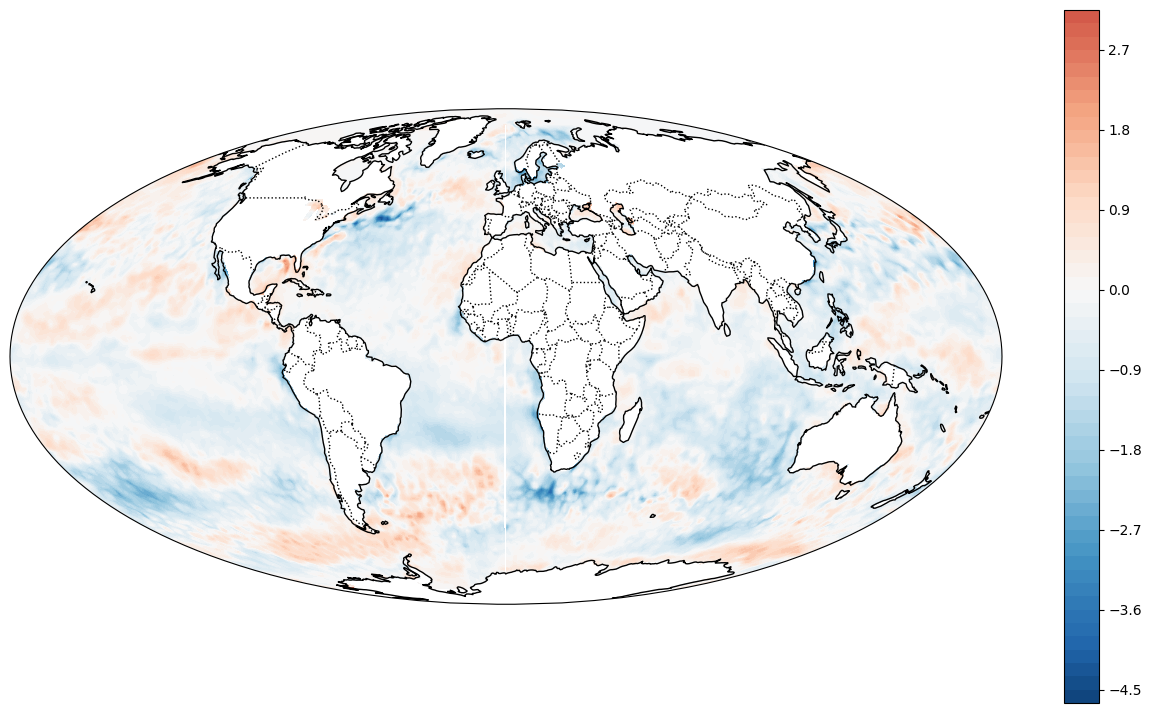

In [11]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

t = 1
cont=ax.contourf(lon, lat, sst[t], levels=60, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-5, vmax=5)

plt.colorbar(cont)

# 해안선 추가
ax.coastlines()
# 국경 추가
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.show()

In [ ]:
def calculate_metrics(df_fcst: pd.DataFrame) -> dict:
    true = df_fcst["y"]
    pred = df_fcst["yhat"]

    mae = (true - pred).abs().mean()
    mape = (true - pred).abs().div(true).mean() * 100
    mse = ((true - pred) ** 2).mean()
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
    }

def normalize_dataset(df: pd.DataFrame, scaler: str = "MinMax") -> tuple:
    """
    모델 훈련에 사용할 데이터셋을 정규화한 값과 해당 Scaler를 반환한다.

    :param df: Pandas dataframe to apply feature scaling.
    """

    if "date" in df.columns:
        df = df.set_index("date")

    if "y" not in df.columns:
        raise KeyError("Not found target column 'y'")
    else:
        df = df.drop(columns="y").assign(y=df["y"])

    # Feature Scaler
    if scaler == "MinMax":
        feature_scaler = MinMaxScaler(feature_range=(0, 1))
        target_scaler = MinMaxScaler(feature_range=(0, 1))
    elif scaler == "Robust":
        feature_scaler = RobustScaler()
        target_scaler = RobustScaler()

    features_scaled = pd.DataFrame(
        data=feature_scaler.fit_transform(X=df.iloc[:, :-1]),
        index=df.index,
        columns=df.iloc[:, :-1].columns.values,
    )
    target_scaled = target_scaler.fit_transform(X=df.iloc[:, -1].values.reshape(-1, 1))

    return features_scaled, feature_scaler, target_scaled, target_scaler

In [9]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 # 0.001 lr

input_size = 5 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes

fl = ForeCastLSTM()

fl.fit_model(X=X,y=y,input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=num_classes)

[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --